# Ordinal Classes

So far we have discussed how to deal with two challenges facing our model, overfitting and imbalanced data. In the process, we have identified another problem with our model: whilst it is good at identifying when a strong sentiment is being expressed, it is not always good at identifying the direction of the sentiment, ie whether it is positive or negative. This is poor as there is a natural order between our class labels:

* 0: Negative
* 1: Moderate_negative
* 2: Neutral
* 3: Moderarte_positive
* 4: Positive

Therefore we would prefer for a moderate_positive case to be misclassified as positive or neutral than say moderate_negative, which currently occurs a lot in our model. One way we can attempt to do this is to increase the loss for misclassifications that we want to discourage. Hence, we punish the model more severely for misclassifying positive as negative than we do if it misclassified positive as moderate_postive.

In [2]:
import random, os
import numpy as np
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from datasets import load_dataset
ds2 = load_dataset("FinGPT/fingpt-sentiment-train", split="train")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/529 [00:00<?, ?B/s]

data/train-00000-of-00001-dabab110260ac9(…):   0%|          | 0.00/6.42M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/76772 [00:00<?, ? examples/s]

In [5]:
mapping_5 = {
    "strong negative": "negative",
    "moderately negative": "moderate_negative",
    "mildly negative": "moderate_negative",
    "negative": "negative",
    "neutral": "neutral",
    "mildly positive": "moderate_positive",
    "moderately positive": "moderate_positive",
    "positive": "positive",
    "strong positive": "positive"
}

In [6]:
def map_to_5(example):
    example["label_5"] = mapping_5[example["output"]]
    return example

ds2 = ds2.map(map_to_5)

Map:   0%|          | 0/76772 [00:00<?, ? examples/s]

In [ ]:
# Here we have changed our mapping to reflect the ordinality of our classes

ordered_labels = [
    "negative",
    "moderate_negative",
    "neutral",
    "moderate_positive",
    "positive",
]

id2label = {i: lab for i, lab in enumerate(ordered_labels)}
label2id = {lab: i for i, lab in id2label.items()}


def encode_label(example):
    example["label"] = label2id[example["label_5"]]
    return example

ds2 = ds2.map(encode_label)

Map:   0%|          | 0/76772 [00:00<?, ? examples/s]

In [8]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def tokenize(batch):
    return tokenizer(batch["input"], truncation=True, padding="max_length", max_length=128)

ds2 = ds2.map(tokenize, batched=True)
ds2 = ds2.train_test_split(test_size=0.2)   # create validation set

ds2 = ds2.remove_columns(["output", "label_5", "input"])  # keep only tokenized fields + label
ds2.set_format("torch")

Map:   0%|          | 0/76772 [00:00<?, ? examples/s]

In [10]:
from transformers import TrainerCallback
import numpy as np

class TrainAccuracyCallback(TrainerCallback):
    def __init__(self):
        self.trainer = None  # Will be set after Trainer initialization

    def on_epoch_end(self, args, state, control, **kwargs):
        if self.trainer is None:
            # This case should ideally not be reached if setup correctly
            raise ValueError("Trainer instance not set in TrainAccuracyCallback.")

        train_ds = self.trainer.train_dataset

        # Get predictions on the training set
        preds_output = self.trainer.predict(train_ds, metric_key_prefix="train")
        logits = preds_output.predictions
        labels = preds_output.label_ids
        preds = np.argmax(logits, axis=1)

        # Compute accuracy
        train_acc = (preds == labels).mean()

        # Log accuracy into trainer history
        self.trainer.state.log_history.append({
            "epoch": state.epoch,
            "train_accuracy": train_acc,
            "step": state.global_step
        })

        print(f"Training Accuracy (epoch {state.epoch:.0f}): {train_acc:.4f}")

# Ordinal Loss Function

In order to enforce the ordinal features of our classes we introduce a simple ordinal loss function:

$$
\mathcal{L}
= \frac{1}{N} \sum_{i=1}^{N} \sum_{k=0}^{K-1} p_i(k)\, \lvert y_i - k \rvert .
$$

This is the simplest possible ordinal loss function and is more for completeness than as a considered choice. It is unlikely that a linear weighting such as this would be the best choice, as we want to punish negative and positive misclassification severely relative to positive and moderate positive misclassification. However, due to the time and compute constraints, this section serves as an example for how an ordinal loss function could be implemented. As a result the model parameters have not been fine-tuned and performance is likely not representative of the performance of ordinal models generally.


Other more sophisticated models such as CORAL [1] and Oridnal Cross-Entropy Loss [2] are available and would likely achieve better performance

### Why are these better?

CORAL for example transfors a K-class ordinal problem into K-1 binary classification tasks, each representing $P(y>k)$. So instead of predicting a distribution over classes directly, the model predicts the probability that the label is greater than each threshold. This enforces monotonicity:

$$P(y>0) \ge P(y>1) \ge ... $$

This means the model cannout output nonsense like:

* $P(y>2)=0.9$
* $P(y>1)=0.3$

Which can currently occur in softmax models, like the one we use.






In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import torch, numpy as np
from evaluate import load
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F


metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"accuracy": metric.compute(predictions=preds, references=labels)["accuracy"]}


# Freeze 6 layers 

for param in model.bert.encoder.layer[:6].parameters():
    param.requires_grad = False


# Increase dropout aggressively
model.bert.config.hidden_dropout_prob = 0.2
model.bert.config.attention_probs_dropout_prob = 0.2

def ordinal_direction_loss(logits, targets):
    """
    logits: (batch, 5)
    targets: (batch,)
    """
    probs = F.softmax(logits, dim=1)
    K = logits.size(1)

    classes = torch.arange(K, device=logits.device).unsqueeze(0)  # shape (1,5)
    y = targets.unsqueeze(1)                                      # shape (batch,1)

    cost = torch.abs(y - classes).float()                         # |y - k|
    loss = torch.sum(cost * probs, dim=1)
    return loss.mean()



class OrdinalTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = ordinal_direction_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss



# Training settings to reduce overfitting

args = TrainingArguments(
    output_dir="./finbert_5",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=8e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=8,
    weight_decay=0.05,
    warmup_ratio=0.2,
    fp16=True,
    report_to="none",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    max_grad_norm=1.0,
    seed=42,
    data_seed=42
)

train_acc_callback = TrainAccuracyCallback() # Instantiate the callback

trainer = OrdinalTrainer(
    model=model,
    args=args,
    train_dataset=ds2["train"],
    eval_dataset=ds2["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2), train_acc_callback]
)

train_acc_callback.trainer = trainer # Set the trainer instance

trainer.train()

/tmp/ipython-input-3465333838.py:79: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `OrdinalTrainer.__init__`. Use `processing_class` instead.
  trainer = OrdinalTrainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.766100,0.520036,0.691176
2,0.384700,0.328413,0.753240
3,0.221800,0.204477,0.876913
4,0.175400,0.181964,0.892218
5,0.157800,0.169750,0.897818
6,0.136100,0.160360,0.903419
7,0.125400,0.156260,0.905764
8,0.121200,0.154150,0.906936


Training Accuracy (epoch 1): 0.6992
Training Accuracy (epoch 2): 0.7625
Training Accuracy (epoch 3): 0.8952
Training Accuracy (epoch 4): 0.9138
Training Accuracy (epoch 5): 0.9224
Training Accuracy (epoch 6): 0.9288
Training Accuracy (epoch 7): 0.9323
Training Accuracy (epoch 8): 0.9342


TrainOutput(global_step=15360, training_loss=0.3003147547443708, metrics={'train_runtime': 3576.7484, 'train_samples_per_second': 137.369, 'train_steps_per_second': 4.294, 'total_flos': 3.2319853911422976e+16, 'train_loss': 0.3003147547443708, 'epoch': 8.0})

## Model Performance

As mentioned above this model has not been fine-tuned and so the chosen parameters have just been taken from previous sections. As we can see the model fits well but the validation accuracy is, comparatively, low.

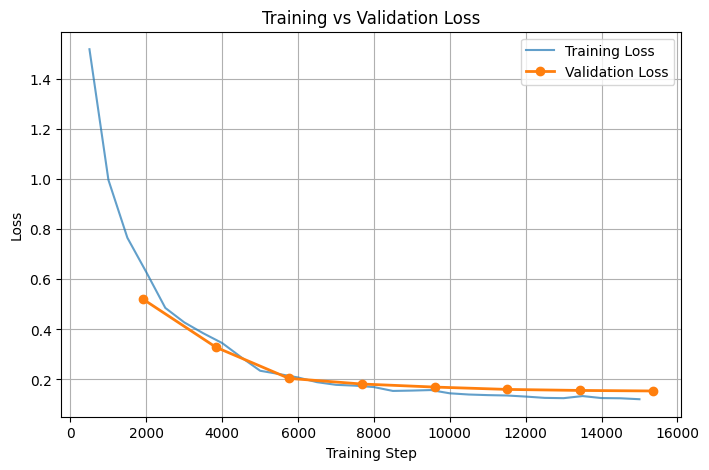

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Load logs
logs = pd.DataFrame(trainer.state.log_history)

train_loss = logs.dropna(subset=["loss"])
eval_loss = logs.dropna(subset=["eval_loss"])

plt.figure(figsize=(8,5))

# Training loss is logged per step
plt.plot(train_loss["step"], train_loss["loss"], label="Training Loss", alpha=0.7)

# Validation loss is logged per epoch, so use epoch instead of step
plt.plot(eval_loss["step"], eval_loss["eval_loss"], marker="o", label="Validation Loss", linewidth=2)

plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

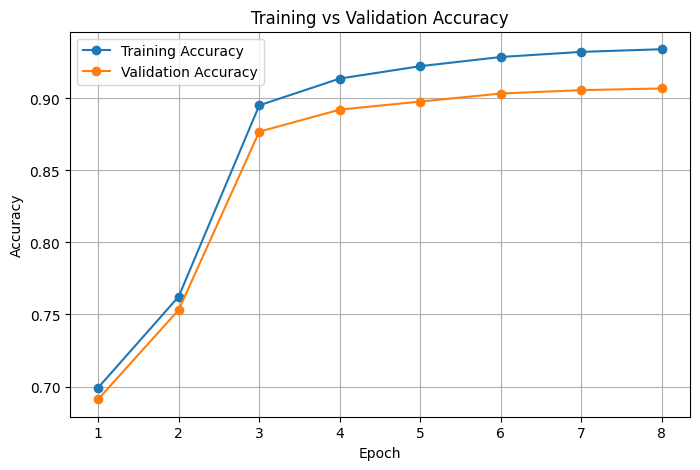

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer.state.log_history)

# Check if 'train_accuracy' exists before processing
if "train_accuracy" in logs.columns:
    train_acc = logs.dropna(subset=["train_accuracy"])
else:
    train_acc = pd.DataFrame()
    print("Warning: 'train_accuracy' column not found in logs. Training accuracy plot will be skipped.")

# Check if 'eval_accuracy' exists before processing
# The Trainer should log 'eval_accuracy' if compute_metrics is provided.
if "eval_accuracy" in logs.columns:
    eval_acc = logs.dropna(subset=["eval_accuracy"])
else:
    eval_acc = pd.DataFrame()
    print("Warning: 'eval_accuracy' column not found in logs. Validation accuracy plot will be skipped.")


plt.figure(figsize=(8,5))
plotted_anything = False

if not train_acc.empty:
    plt.plot(train_acc["epoch"], train_acc["train_accuracy"], marker="o", label="Training Accuracy")
    plotted_anything = True

if not eval_acc.empty:
    plt.plot(eval_acc["epoch"], eval_acc["eval_accuracy"], marker="o", label="Validation Accuracy")
    plotted_anything = True

if plotted_anything:
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No accuracy data available to plot after training.")

In [15]:
preds = trainer.predict(ds2["test"])
pred_labels = np.argmax(preds.predictions, axis=1)

from sklearn.metrics import classification_report
print(classification_report(preds.label_ids, pred_labels, target_names=list(id2label.values())))

                   precision    recall  f1-score   support

         negative       0.95      0.92      0.94      2439
moderate_negative       0.77      0.81      0.79      1026
          neutral       0.91      0.92      0.92      5835
moderate_positive       0.78      0.81      0.80      1772
         positive       0.96      0.94      0.95      4283

         accuracy                           0.91     15355
        macro avg       0.88      0.88      0.88     15355
     weighted avg       0.91      0.91      0.91     15355



## Confuion Matrix

Unfortunately despite the change in loss function we still see similar performance to previous models, as the moderate classes are still getting confused. Therefore it is likely that a more punishing loss function is required (superlinear rather than linear). 

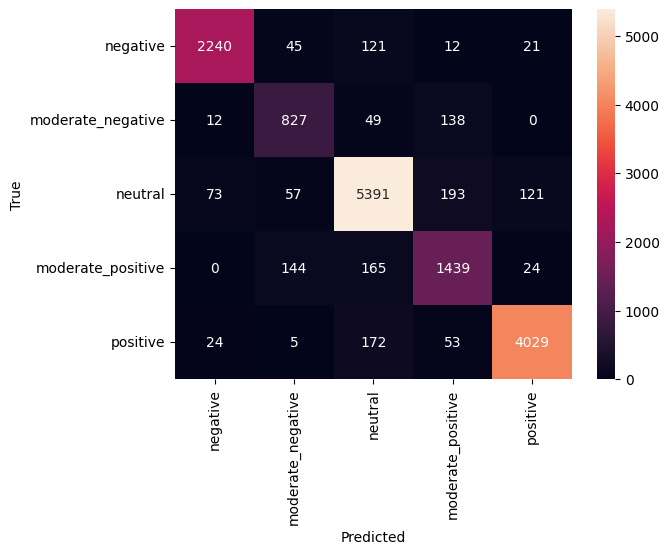

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(preds.label_ids, pred_labels)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [17]:
trainer.save_model("/content/drive/MyDrive/finbert_5class_model_v5")
tokenizer.save_pretrained("/content/drive/MyDrive/finbert_5class_model_v5")

('/content/drive/MyDrive/finbert_5class_model_v5/tokenizer_config.json',
 '/content/drive/MyDrive/finbert_5class_model_v5/special_tokens_map.json',
 '/content/drive/MyDrive/finbert_5class_model_v5/vocab.txt',
 '/content/drive/MyDrive/finbert_5class_model_v5/added_tokens.json',
 '/content/drive/MyDrive/finbert_5class_model_v5/tokenizer.json')

# Conclusion on finBERT and the Granularity Problem

Overall, FinBERT provides a strong foundation for financial sentiment analysis and performs well even when adapted to a more granular, five-class prediction task. With appropriate regularisation: freezing early layers, weight decay, and dropout, the model maintains high accuracy without severe overfitting. However, our analysis shows that FinBERT still struggles with ordinal structure and directionality in economic language (eg classifying a rise in unemployment as positive). In particular, the model can correctly classify broad sentiment magnitudes but is less reliable at distinguishing between direction such as moderate positive vs moderate negative, or at interpreting the direction implied by numerical reasoning.

A major contributing factor is the imbalanced dataset: extreme classes are far more common than moderate ones, and FinBERT learns these distributions rather than the underlying ordinal relationships. Class weighting improves this to an extent, but ordinal inconsistencies persist. Because FinBERT treats classes as independent categories rather than ordered labels, it cannot utilise the metric structure that clearly exists within financial sentiment.

If we had 1000× more labelled data, FinBERT’s limitations would be less pronounced. Large datasets naturally provide more examples of subtle sentiment cues, numerical transitions, and moderately positive/negative statements, allowing the model to internalise directional structure without needing explicit ordinal losses. Similarly, with greater compute, we could fine-tune more extensively, unfreezing additional layers, performing multi-stage training, or training larger variants (e.g., RoBERTa-large FinBERT). This would improve granularity while still avoiding overfitting. However, this is not feasible with the currently available time and resources as a single fine-tuning run already takes roughly one hour on a Colab GPU, constraining exploration of larger models or more ambitious optimisation strategies. 

These challenges motivate the next stage of this project: investigating techniques other than standard FinBERT to handle intermediate sentiment levels. By comparing these techniques, we move closer to designing models that not only classify sentiment but understand its intensity and direction, providing the level of granularity required in financial decision-making contexts.



# References

* [1] Cao et al. (2020) – Rank Consistent Ordinal Regression for Neural Networks (CORAL)
* [2] Rennie & Srebro (2005) – Loss Functions for Preference Levels: Regression with Discrete Ordered Labels